# Third Model: 

## Decision Tree Classifier with Reduced Features

The goal of this model is to build a classifier that can recognize the patients who will be readmitted within 30 days of discharge. Our biggest obstacles have been high dimensionality and class imbalance, so we will make sure to be more aggressive and address them in building this model. 

### Methods:

Feature Selection: I will use domain knowledge and statistical significance to select the most important features. 

Category Reduction: I will also bin similar feature categories to reduce noise in the data.

SMOTE: I will use SMOTE to balance the class weights and increase recognition of the minority class.

Removing numerical outliers

Removing special characters



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.datasets import load_iris

%matplotlib inline

In [2]:
#Load in the dataset
diabetes_df = pd.read_csv('/Users/sabrinasayed/Documents/Flatiron/Phase 3/Diabetes_Readmission_Classifier/Diabetes_Classifier_Project/Cleaned Data/cleaned_diabetes_data.csv', index_col=0)

In [3]:
diabetes_df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

## Feature Engineering

Adjusting data types of categorical variables

In [4]:
diabetes_df['admission_type_id'] = diabetes_df['admission_type_id'].astype('object')
diabetes_df['admission_source_id'] = diabetes_df['admission_source_id'].astype('object')
diabetes_df['discharge_disposition_id'] = diabetes_df['discharge_disposition_id'].astype('object')

In [5]:
diabetes_df[['time_in_hospital','num_lab_procedures',
       'num_procedures', 'num_medications','number_diagnoses']].corr()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses
time_in_hospital,1.000000,0.332180,0.188305,0.467897,0.233850
num_lab_procedures,0.332180,1.000000,0.043781,0.258975,0.153981
num_procedures,0.188305,0.043781,1.000000,0.400873,0.086476
num_medications,0.467897,0.258975,0.400873,1.000000,0.259283
number_diagnoses,0.233850,0.153981,0.086476,0.259283,1.000000


### Creating the A1Cmeasurement column: 

Exploring the effect of whether not A1C is measured has some impact on the target variable

In [6]:
diabetes_df['A1Cresult'].value_counts()

A1Cresult
Missing    57128
>8          6239
Norm        3741
>7          2865
Name: count, dtype: int64

In [7]:
temp_table = diabetes_df['A1Cresult'].replace(to_replace=['>8','>7','Norm'], value='Yes')

In [8]:
temp_table

0         Missing
1         Missing
2         Missing
3         Missing
4         Missing
           ...   
101754        Yes
101755        Yes
101756    Missing
101758    Missing
101765    Missing
Name: A1Cresult, Length: 69973, dtype: object

In [9]:
A1Cmeasurement = temp_table.replace(to_replace='Missing', value='No')


In [10]:
A1Cmeasurement = A1Cmeasurement.rename('A1Cmeasurement')

In [11]:
A1Cmeasurement

0          No
1          No
2          No
3          No
4          No
         ... 
101754    Yes
101755    Yes
101756     No
101758     No
101765     No
Name: A1Cmeasurement, Length: 69973, dtype: object

In [12]:
diabetes_df = diabetes_df.join(A1Cmeasurement, how='left')

In [13]:
diabetes_df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,A1Cmeasurement
0,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,No,Otherwise,No
1,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,...,Up,No,No,No,No,No,Ch,Yes,Otherwise,No
2,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,...,No,No,No,No,No,No,No,Yes,Otherwise,No
3,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,...,Up,No,No,No,No,No,Ch,Yes,Otherwise,No
4,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,...,Steady,No,No,No,No,No,Ch,Yes,Otherwise,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,Female,[70-80),1,1,7,9,Unknown,Unknown,50,...,Steady,No,No,No,No,No,Ch,Yes,Otherwise,Yes
101755,Other,Female,[40-50),1,1,7,14,MD,Unknown,73,...,Up,No,No,No,No,No,Ch,Yes,Otherwise,Yes
101756,Other,Female,[60-70),1,1,7,2,MD,Unknown,46,...,Steady,No,No,No,No,No,No,Yes,Otherwise,No
101758,Caucasian,Female,[80-90),1,1,7,5,MC,Unknown,76,...,Up,No,No,No,No,No,Ch,Yes,Otherwise,No


In [14]:
diabetes_df['max_glu_serum'].value_counts()

max_glu_serum
Missing    66625
Norm        1700
>200         936
>300         712
Name: count, dtype: int64

In [15]:
temp_table_2 = diabetes_df['max_glu_serum'].replace(to_replace=['>200','>300','Norm'], value='Yes')

In [16]:
Glucose_Measured = temp_table_2.replace(to_replace='Missing', value='No')

In [17]:
Glucose_Measured = Glucose_Measured.rename('Glucose_Measured')

In [18]:
diabetes_df = diabetes_df.join(Glucose_Measured, how='left')
diabetes_df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,A1Cmeasurement,Glucose_Measured
0,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,Otherwise,No,No
1,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,...,No,No,No,No,No,Ch,Yes,Otherwise,No,No
2,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,...,No,No,No,No,No,No,Yes,Otherwise,No,No
3,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,...,No,No,No,No,No,Ch,Yes,Otherwise,No,No
4,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,...,No,No,No,No,No,Ch,Yes,Otherwise,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,Female,[70-80),1,1,7,9,Unknown,Unknown,50,...,No,No,No,No,No,Ch,Yes,Otherwise,Yes,No
101755,Other,Female,[40-50),1,1,7,14,MD,Unknown,73,...,No,No,No,No,No,Ch,Yes,Otherwise,Yes,No
101756,Other,Female,[60-70),1,1,7,2,MD,Unknown,46,...,No,No,No,No,No,No,Yes,Otherwise,No,No
101758,Caucasian,Female,[80-90),1,1,7,5,MC,Unknown,76,...,No,No,No,No,No,Ch,Yes,Otherwise,No,No


In [19]:
diabetes_df.isna().value_counts()

race   gender  age    admission_type_id  discharge_disposition_id  admission_source_id  time_in_hospital  payer_code  medical_specialty  num_lab_procedures  num_procedures  num_medications  number_outpatient  number_emergency  number_inpatient  diag_1  diag_2  diag_3  number_diagnoses  max_glu_serum  A1Cresult  metformin  repaglinide  nateglinide  chlorpropamide  glimepiride  acetohexamide  glipizide  glyburide  tolbutamide  pioglitazone  rosiglitazone  acarbose  miglitol  troglitazone  tolazamide  examide  citoglipton  insulin  glyburide-metformin  glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  metformin-pioglitazone  change  diabetesMed  readmitted  A1Cmeasurement  Glucose_Measured
False  False   False  False              False                     False                False             False       False              False               False           False            False              False             False             False   False   False   False        

So we created 2 new columns to signify whether or not glucose and Hemoglobin A1C were measured during the patient's visit. If these are statistically significant variables, we will be able to use them as predictors for our model

## Testing statistical significance of features

In [20]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['A1Cmeasurement'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(6.355505830669563,
 0.011701757602602935,
 1,
 array([[ 5124.72605148, 52003.27394852],
        [ 1152.27394852, 11692.72605148]]))

We can reject the null and say that this is in fact a statistically significant variable for our target.

In [21]:
contingency_table

readmitted,<30,Otherwise
A1Cmeasurement,,
No,5199,51929
Yes,1078,11767


In [22]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['A1Cresult'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(7.260008315545734,
 0.06405633904985746,
 3,
 array([[  257.00777443,  2607.99222557],
        [  559.67591785,  5679.32408215],
        [ 5124.72605148, 52003.27394852],
        [  335.59025624,  3405.40974376]]))

The actual A1C result is not statistically significant here so we won't include this in our reduced dataframe.

In [23]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['age'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(188.13382228360737,
 1.0114177173089188e-35,
 9,
 array([[1.37250225e+01, 1.39274977e+02],
        [4.79030197e+01, 4.86096980e+02],
        [1.00560459e+02, 1.02043954e+03],
        [2.41488631e+02, 2.45051137e+03],
        [6.12512769e+02, 6.21548723e+03],
        [1.10777976e+03, 1.12412202e+04],
        [1.40694937e+03, 1.42770506e+04],
        [1.59228202e+03, 1.61577180e+04],
        [9.95916339e+02, 1.01060837e+04],
        [1.57882612e+02, 1.60211739e+03]]))

Age is statistically signficant.

In [24]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['gender'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(0.6113260258097654,
 0.7366348140607145,
 2,
 array([[3.33966577e+03, 3.38893342e+04],
        [2.93706511e+03, 2.98039349e+04],
        [2.69118088e-01, 2.73088191e+00]]))

Gender is not statistically significant

In [25]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['race'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(18.210752754882044,
 0.002693546379127181,
 5,
 array([[1.13253862e+03, 1.14924614e+04],
        [4.37765424e+01, 4.44223458e+02],
        [4.69090769e+03, 4.76010923e+04],
        [1.34559044e+02, 1.36544096e+03],
        [1.03161934e+02, 1.04683807e+03],
        [1.72056165e+02, 1.74594384e+03]]))

Race is statistically significant

In [26]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['admission_type_id'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(18.872430526679967,
 0.008596497460928193,
 7,
 array([[3.18151404e+03, 3.22844860e+04],
        [1.14841659e+03, 1.16535834e+04],
        [1.23659762e+03, 1.25484024e+04],
        [8.07354265e-01, 8.19264573e+00],
        [2.76832807e+02, 2.80916719e+03],
        [4.05112429e+02, 4.11088757e+03],
        [1.61470853e+00, 1.63852915e+01],
        [2.61044546e+01, 2.64895545e+02]]))

Admission type is statistically significant

In [27]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['payer_code'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(133.09886182224145,
 4.735512091613653e-20,
 17,
 array([[3.04731382e+02, 3.09226862e+03],
        [1.01367813e+01, 1.02863219e+02],
        [1.16169308e+02, 1.17883069e+03],
        [1.73939991e+02, 1.76506001e+03],
        [3.33706430e+01, 3.38629357e+02],
        [8.97060295e-02, 9.10293971e-01],
        [3.57388821e+02, 3.62661118e+03],
        [1.77456467e+03, 1.80074353e+04],
        [1.94213554e+02, 1.97078645e+03],
        [2.87059294e+00, 2.91294071e+01],
        [5.80398011e+01, 5.88960199e+02],
        [5.56177383e+00, 5.64382262e+01],
        [4.09956555e+01, 4.16004345e+02],
        [3.31912309e+00, 3.36808769e+01],
        [2.96299015e+02, 3.00670098e+03],
        [1.66404685e+02, 1.68859532e+03],
        [2.72840889e+03, 2.76865911e+04],
        [1.04956054e+01, 1.06504395e+02]]))

Payer code is statistically significant

In [28]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['time_in_hospital'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(274.18868404668183,
 5.92540801142587e-51,
 13,
 array([[  939.22212854,  9530.77787146],
        [ 1092.44002687, 11085.55997313],
        [ 1120.15918997, 11366.84081003],
        [  845.29991568,  8577.70008432],
        [  600.76127935,  6096.23872065],
        [  453.01544882,  4596.98455118],
        [  350.03292699,  3551.96707301],
        [  255.03424178,  2587.96575822],
        [  171.42822231,  1739.57177769],
        [  135.09728038,  1370.90271962],
        [  106.57076301,  1081.42923699],
        [   82.08101696,   832.91898304],
        [   68.26628843,   692.73371157],
        [   57.59127092,   584.40872908]]))

Time in hospital is statistically significant

In [29]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['num_lab_procedures'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(227.33783363021905,
 2.190847541795524e-09,
 115,
 array([[2.02197390e+02, 2.05180261e+03],
        [6.93427608e+01, 7.03657239e+02],
        [4.53912509e+01, 4.60608749e+02],
        [2.63735727e+01, 2.67626427e+02],
        [1.91073843e+01, 1.93892616e+02],
        [1.78514999e+01, 1.81148500e+02],
        [2.32338616e+01, 2.35766138e+02],
        [2.38618038e+01, 2.42138196e+02],
        [6.10898061e+01, 6.19910194e+02],
        [5.21192031e+01, 5.28880797e+02],
        [4.30588941e+01, 4.36941106e+02],
        [3.31015249e+01, 3.35898475e+02],
        [2.64632787e+01, 2.68536721e+02],
        [2.32338616e+01, 2.35766138e+02],
        [2.53868063e+01, 2.57613194e+02],
        [3.21147585e+01, 3.25885241e+02],
        [4.23412459e+01, 4.29658754e+02],
        [4.31486002e+01, 4.37851400e+02],
        [6.36912809e+01, 6.46308719e+02],
        [5.15809669e+01, 5.23419033e+02],
        [4.79030197e+01, 4.86096980e+02],
        [4.44941906e+01, 4.51505809e+02],
        [5.36442056e+01, 

Number of lab procedures is statistically significant

In [30]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['diag_1'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(1434.0837881144912,
 9.395940707022191e-54,
 694,
 array([[0.08970603, 0.91029397],
        [0.71764824, 7.28235176],
        [0.17941206, 1.82058794],
        ...,
        [0.08970603, 0.91029397],
        [0.08970603, 0.91029397],
        [0.71764824, 7.28235176]]))

Primary diagnosis is statistically significant

In [31]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['num_medications'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(240.31918893838173,
 1.8562809970227165e-19,
 74,
 array([[1.93765024e+01, 1.96623498e+02],
        [3.50750575e+01, 3.55924942e+02],
        [6.35118689e+01, 6.44488131e+02],
        [1.02803110e+02, 1.04319689e+03],
        [1.42901705e+02, 1.45009830e+03],
        [1.87665014e+02, 1.90433499e+03],
        [2.38528332e+02, 2.42047167e+03],
        [2.89122533e+02, 2.93387747e+03],
        [3.24107884e+02, 3.28889212e+03],
        [3.45727038e+02, 3.50827296e+03],
        [3.60349120e+02, 3.65665088e+03],
        [3.80532977e+02, 3.86146702e+03],
        [3.82057980e+02, 3.87694202e+03],
        [3.44650565e+02, 3.49734943e+03],
        [3.49225573e+02, 3.54377443e+03],
        [3.26888771e+02, 3.31711123e+03],
        [2.92082832e+02, 2.96391717e+03],
        [2.63556315e+02, 2.67444369e+03],
        [2.32159204e+02, 2.35584080e+03],
        [2.11437111e+02, 2.14556289e+03],
        [1.83448830e+02, 1.86155117e+03],
        [1.63803210e+02, 1.66219679e+03],
        [1.40210524e+02, 

Number of medications is statistically significant

In [32]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['max_glu_serum'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(6.9942155454614605,
 0.07208237144251027,
 3,
 array([[   83.96484358,   852.03515642],
        [   63.87069298,   648.12930702],
        [ 5976.66421334, 60648.33578666],
        [  152.5002501 ,  1547.4997499 ]]))

The glucose result is not statistically significant

In [33]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['Glucose_Measured'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 



(5.892279472467756,
 0.015207403378144534,
 1,
 array([[ 5976.66421334, 60648.33578666],
        [  300.33578666,  3047.66421334]]))

Glucose measured is statistically significant!

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


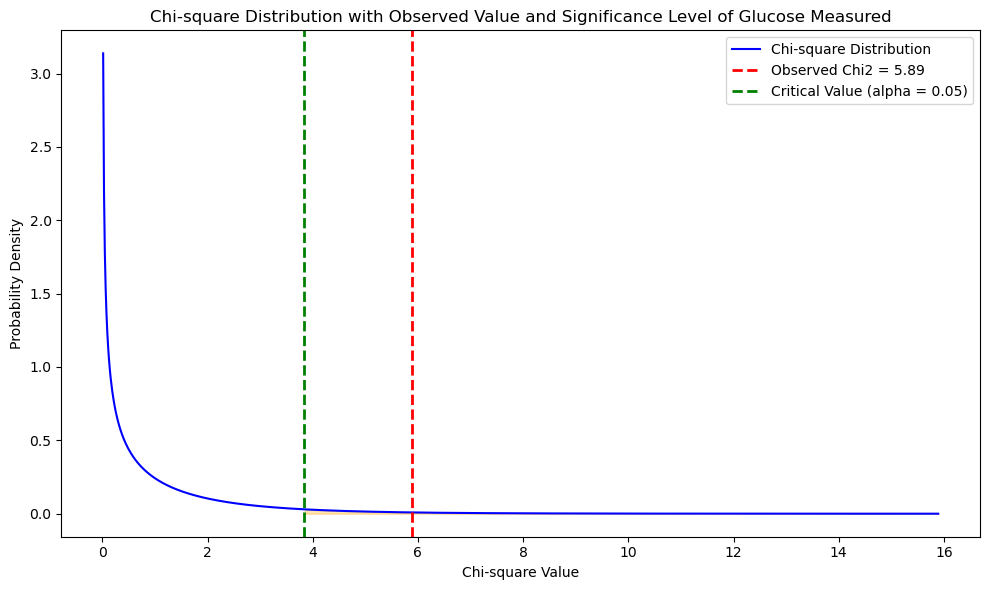

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chi2

# Generate the contingency table
contingency_table = pd.crosstab(diabetes_df['Glucose_Measured'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2_stat, p, dof, expected = chi2_contingency(contingency_table)

# Define the critical chi-square value for alpha = 0.05
alpha = 0.05
critical_value = chi2.ppf(1 - alpha, dof)

# Generate values for the chi-square distribution curve
x_values = np.linspace(0, chi2_stat + 10, 1000)
y_values = chi2.pdf(x_values, dof)

# Plot the chi-square distribution curve
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label="Chi-square Distribution", color="blue")

# Add a vertical line for the observed chi-square value
plt.axvline(chi2_stat, color="red", linestyle="--", linewidth=2, label=f"Observed Chi2 = {chi2_stat:.2f}")

# Add a vertical line for the critical value at alpha = 0.05
plt.axvline(critical_value, color="green", linestyle="--", linewidth=2, label=f"Critical Value (alpha = {alpha})")

# Fill the rejection region
plt.fill_between(x_values, 0, y_values, where=(x_values >= critical_value), color='orange', alpha=0.3)

# Display p-value, chi-square, and significance level
plt.text(chi2_stat + 1, max(y_values) * 0.6, f"p-value: {p:.4f}", color='red', ha='center')
plt.text(critical_value + 1, max(y_values) * 0.7, f"alpha = {alpha}", color='green', ha='center')
plt.xlabel("Chi-square Value")
plt.ylabel("Probability Density")
plt.title("Chi-square Distribution with Observed Value and Significance Level of Glucose Measured")
plt.legend()

plt.tight_layout()
plt.savefig('Glucose_Measured_Significance')


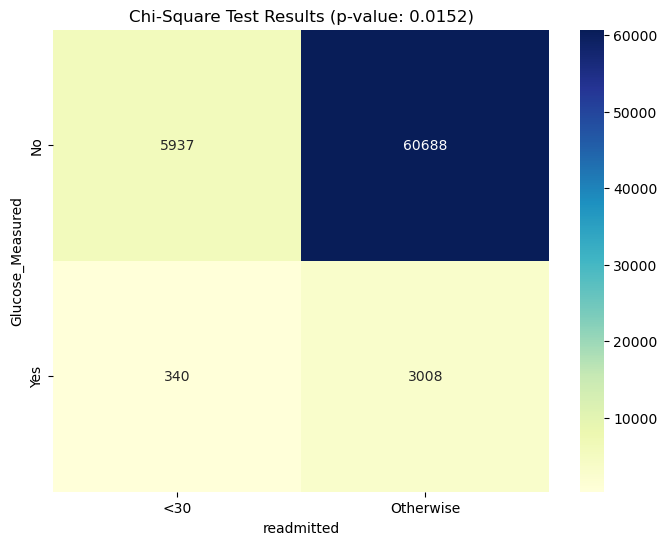

In [35]:
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title(f"Chi-Square Test Results (p-value: {p:.4f})")
plt.savefig('Glucose_Measured_Contingency.png')


In [36]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['num_lab_procedures'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(227.33783363021905,
 2.190847541795524e-09,
 115,
 array([[2.02197390e+02, 2.05180261e+03],
        [6.93427608e+01, 7.03657239e+02],
        [4.53912509e+01, 4.60608749e+02],
        [2.63735727e+01, 2.67626427e+02],
        [1.91073843e+01, 1.93892616e+02],
        [1.78514999e+01, 1.81148500e+02],
        [2.32338616e+01, 2.35766138e+02],
        [2.38618038e+01, 2.42138196e+02],
        [6.10898061e+01, 6.19910194e+02],
        [5.21192031e+01, 5.28880797e+02],
        [4.30588941e+01, 4.36941106e+02],
        [3.31015249e+01, 3.35898475e+02],
        [2.64632787e+01, 2.68536721e+02],
        [2.32338616e+01, 2.35766138e+02],
        [2.53868063e+01, 2.57613194e+02],
        [3.21147585e+01, 3.25885241e+02],
        [4.23412459e+01, 4.29658754e+02],
        [4.31486002e+01, 4.37851400e+02],
        [6.36912809e+01, 6.46308719e+02],
        [5.15809669e+01, 5.23419033e+02],
        [4.79030197e+01, 4.86096980e+02],
        [4.44941906e+01, 4.51505809e+02],
        [5.36442056e+01, 

Number of Lab procedures is statistically significant

In [37]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['insulin'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(50.626250842006954,
 5.87644764524392e-11,
 3,
 array([[  656.73784174,  6664.26215826],
        [ 3073.14915753, 31184.85084247],
        [ 1939.17523902, 19677.82476098],
        [  607.93776171,  6169.06223829]]))

Insulin measurement is also statistically significant

In [38]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['change'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(14.983439258895487,
 0.00010845884202377609,
 1,
 array([[ 2824.93257399, 28666.06742601],
        [ 3452.06742601, 35029.93257399]]))

Change in medication is statistically significant

In [39]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table to 
contingency_table = pd.crosstab(diabetes_df['diabetesMed'], diabetes_df['readmitted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected 


(54.05200384318759,
 1.9525288585115278e-13,
 1,
 array([[ 1496.29657153, 15183.70342847],
        [ 4780.70342847, 48512.29657153]]))

Prescribed diabetes medication is also statisically significant

## Feature Selection

Based on domain knowledge and statistical significance of variables


In [40]:
reduced_df = diabetes_df[['race', 'age', 'payer_code',
                                           'admission_type_id','time_in_hospital',
                                           'num_lab_procedures','diag_1', 'num_medications',
                                           'Glucose_Measured', 'A1Cmeasurement',
                                           'insulin','change', 'readmitted']]
reduced_df


,race,age,payer_code,admission_type_id,time_in_hospital,num_lab_procedures,diag_1,num_medications,Glucose_Measured,A1Cmeasurement,insulin,change,readmitted
0,Caucasian,[0-10),Unknown,6,1,41,250.83,1,No,No,No,No,Otherwise
1,Caucasian,[10-20),Unknown,1,3,59,276,18,No,No,Up,Ch,Otherwise
2,AfricanAmerican,[20-30),Unknown,1,2,11,648,13,No,No,No,No,Otherwise
3,Caucasian,[30-40),Unknown,1,2,44,8,16,No,No,Up,Ch,Otherwise
4,Caucasian,[40-50),Unknown,1,1,51,197,8,No,No,Steady,Ch,Otherwise
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,[70-80),Unknown,1,9,50,574,33,No,Yes,Steady,Ch,Otherwise
101755,Other,[40-50),MD,1,14,73,592,26,No,Yes,Up,Ch,Otherwise
101756,Other,[60-70),MD,1,2,46,996,17,No,No,Steady,No,Otherwise
101758,Caucasian,[80-90),MC,1,5,76,292,22,No,No,Up,Ch,Otherwise


## Reducing Categories/Cardinality

Grouping together similar categories to reduce dimensionality

There's very few values for for Hispanic and Asian patients so we will group them together with other.

In [41]:
reduced_df['race'].value_counts()
# Group together Unknown, Hispanic, Other, and Asian into one category called 'Other'
reduced_df['race'] = reduced_df['race'].replace(['Unknown', 'Hispanic', 'Other', 'Asian'], 'Other')

# Display the updated race distribution
reduced_df['race'].value_counts()

#Fix the data type
reduced_df['race'] = reduced_df['race'].astype('object')

reduced_df['race']



/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_60139/1106187330.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['race'] = reduced_df['race'].replace(['Unknown', 'Hispanic', 'Other', 'Asian'], 'Other')
/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_60139/1106187330.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['race'] = reduced_df['race'].astype('object')


0               Caucasian
1               Caucasian
2         AfricanAmerican
3               Caucasian
4               Caucasian
               ...       
101754          Caucasian
101755              Other
101756              Other
101758          Caucasian
101765          Caucasian
Name: race, Length: 69973, dtype: object

The special characters may be a source noise that distracts the model so we will transform them into numerical representations.

In [42]:
#Convert age to numeric representations
def age_to_numeric(age_range):
    if age_range == '[0-10)':
        return 5
    elif age_range == '[10-20)':
        return 15
    elif age_range == '[20-30)':
        return 25
    elif age_range == '[30-40)':
        return 35
    elif age_range == '[40-50)':
        return 45
    elif age_range == '[50-60)':
        return 55
    elif age_range == '[60-70)':
        return 65
    elif age_range == '[70-80)':
        return 75
    elif age_range == '[80-90)':
        return 85
    elif age_range == '[90-100)':
        return 95
    else:
        return None

reduced_df['age'] = reduced_df['age'].apply(age_to_numeric)


/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_60139/2972771319.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['age'] = reduced_df['age'].apply(age_to_numeric)


In [43]:
reduced_df['age'].value_counts()

age
75    17750
65    15684
55    12349
85    11102
45     6828
35     2692
95     1760
25     1121
15      534
5       153
Name: count, dtype: int64

Grouping Admission Type Categories

In [44]:
reduced_df['admission_type_id'].value_counts()

admission_type_id
1    35466
3    13785
2    12802
6     4516
5     3086
8      291
7       18
4        9
Name: count, dtype: int64

Admission Type mapping:
1,Emergency
2,Urgent
3,Elective
4,Newborn
5,Not Available
6,NULL
7,Trauma Center
8,Not Mapped

We'll group together Emergency and Urgent and group together Not Available, Null, and Not Mapped to reduce cardinality.

The new categories;
1. Emergency/Urgent
2. Elective
3. Newborn
4. Not Available, Null, Not Mapped
5. Trauma Center

In [45]:
#Group together similar admission types to reduce dimensionality
reduced_df['admission_type_id'] = reduced_df['admission_type_id'].replace({
    2: 1,
    3: 2,
    4: 3,
    5: 4,
    6: 4,
    8: 4,
    7: 5
})

# Verify the changes
print(reduced_df['admission_type_id'].value_counts().sort_index())



admission_type_id
1    48268
2    13785
3        9
4     7893
5       18
Name: count, dtype: int64


/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_60139/1521505962.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  reduced_df['admission_type_id'] = reduced_df['admission_type_id'].replace({
/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_60139/1521505962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['admission_type_id'] = reduced_df['admission_type_id'].replace({


Starting with 695 unique values for diagnosis 1

In [46]:
diabetes_df['diag_1'].value_counts()

diag_1
414    5209
428    3876
786    3040
410    2774
486    2362
       ... 
671       1
148       1
826       1
870       1
V51       1
Name: count, Length: 695, dtype: int64

Grouping together diagnosis categories:

In [47]:
def categorize_diagnosis(code):
    code = str(code).strip()
    if code.startswith('250'):
        return 'Diabetes'
    elif 'V' in code or 'E' in code:
        return 'Other'
    elif code.isdigit():
        code_int = int(code)
        if 390 <= code_int <= 459 or code == '785':
            return 'Circulatory System'
        elif 460 <= code_int <= 519 or code == '786':
            return 'Respiratory System'
        elif 520 <= code_int <= 579 or code == '787':
            return 'Digestive System'
        elif 800 <= code_int <= 999:
            return 'Injury'
        elif 710 <= code_int <= 739:
            return 'Musculoskeletal System'
        elif 580 <= code_int <= 629 or code == '788':
            return 'Genitourinary System'
        elif 140 <= code_int <= 239:
            return 'Neoplasms'
        elif code in ['780', '781', '784'] or 790 <= code_int <= 799 or \
             (240 <= code_int <= 279 and code != '250') or \
             680 <= code_int <= 709 or code == '782' or \
             1 <= code_int <= 139 or 290 <= code_int <= 319 or \
             280 <= code_int <= 289 or 320 <= code_int <= 359 or \
             630 <= code_int <= 679 or 360 <= code_int <= 389 or \
             540 <= code_int <= 759:
            return 'Other'
    return 'Other'

# Ensure diag_1 is string type before applying the function
reduced_df['diag_1'] = reduced_df['diag_1'].astype(str)
reduced_df['diag_1'] = reduced_df['diag_1'].apply(categorize_diagnosis)
reduced_df['diag_1'].value_counts()

/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_60139/3106606842.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['diag_1'] = reduced_df['diag_1'].astype(str)
/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_60139/3106606842.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['diag_1'] = reduced_df['diag_1'].apply(categorize_diagnosis)


diag_1
Circulatory System        21384
Other                     12132
Respiratory System         9486
Digestive System           6487
Diabetes                   5748
Injury                     4694
Musculoskeletal System     4064
Genitourinary System       3440
Neoplasms                  2538
Name: count, dtype: int64

In [48]:
reduced_df['diag_1']=reduced_df['diag_1'].astype('object')


/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_60139/199267361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['diag_1']=reduced_df['diag_1'].astype('object')


In [49]:
reduced_df['diag_1']

0                     Diabetes
1                        Other
2                        Other
3                        Other
4                    Neoplasms
                  ...         
101754        Digestive System
101755    Genitourinary System
101756                  Injury
101758                   Other
101765        Digestive System
Name: diag_1, Length: 69973, dtype: object

There are 10 unique values for diagnosis 1 now.

In [50]:
reduced_df['admission_type_id']=reduced_df['admission_type_id'].astype('object')

/var/folders/rj/3yvmqxnj3d17zpgh8wpywxvr0000gn/T/ipykernel_60139/1711524336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['admission_type_id']=reduced_df['admission_type_id'].astype('object')


Checking for remaining outliers in numeric columns

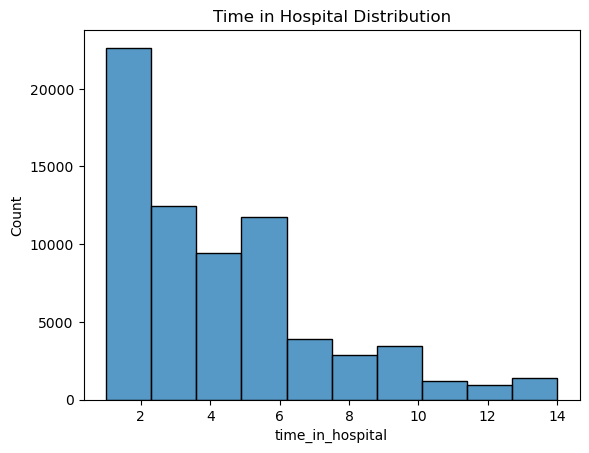

In [51]:
sns.histplot(data=reduced_df, x= 'time_in_hospital', bins=10)
plt.title('Time in Hospital Distribution')
plt.savefig('Time_in_Hospital_Distribution.png')

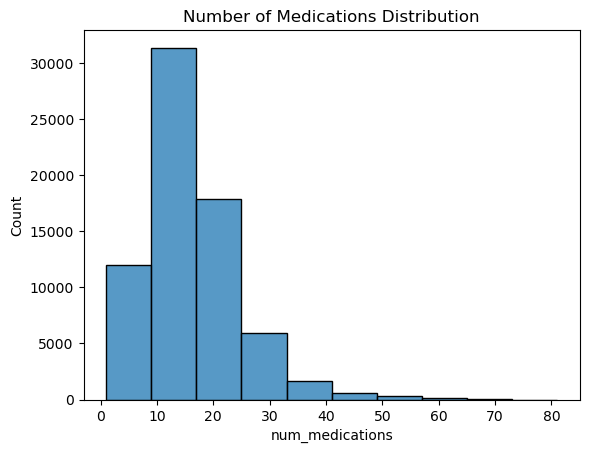

In [52]:
sns.histplot(data=reduced_df, x= 'num_medications', bins=10)
plt.title('Number of Medications Distribution')
plt.savefig('Number_of_Medications_Distribution.png')

Text(0.5, 1.0, 'Number of Medications Distribution')

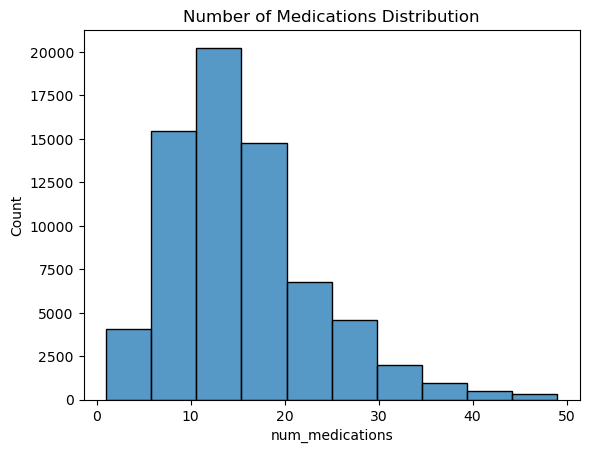

In [53]:
#Remove outliers in num_medications
reduced_df = reduced_df[reduced_df['num_medications'] < 50]

sns.histplot(data=reduced_df, x= 'num_medications', bins=10)
plt.title('Number of Medications Distribution')

Text(0.5, 1.0, 'Number of Lab Procedures Distribution')

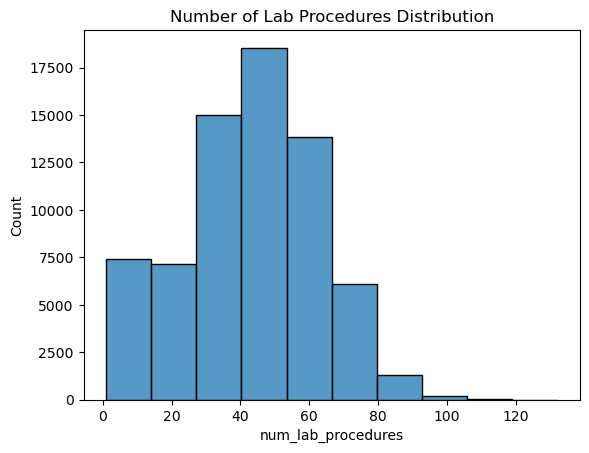

In [54]:
sns.histplot(data=reduced_df, x= 'num_lab_procedures', bins=10)
plt.title('Number of Lab Procedures Distribution')

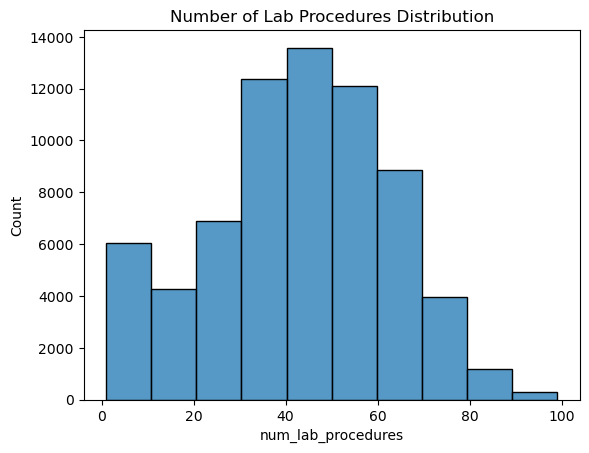

In [55]:
# Remove outliers in num_lab_procedures
reduced_df = reduced_df[reduced_df['num_lab_procedures'] < 100]

sns.histplot(data=reduced_df, x= 'num_lab_procedures', bins=10)
plt.title('Number of Lab Procedures Distribution')
plt.savefig('Number_of_Lab_Procedures_Distribution.png')

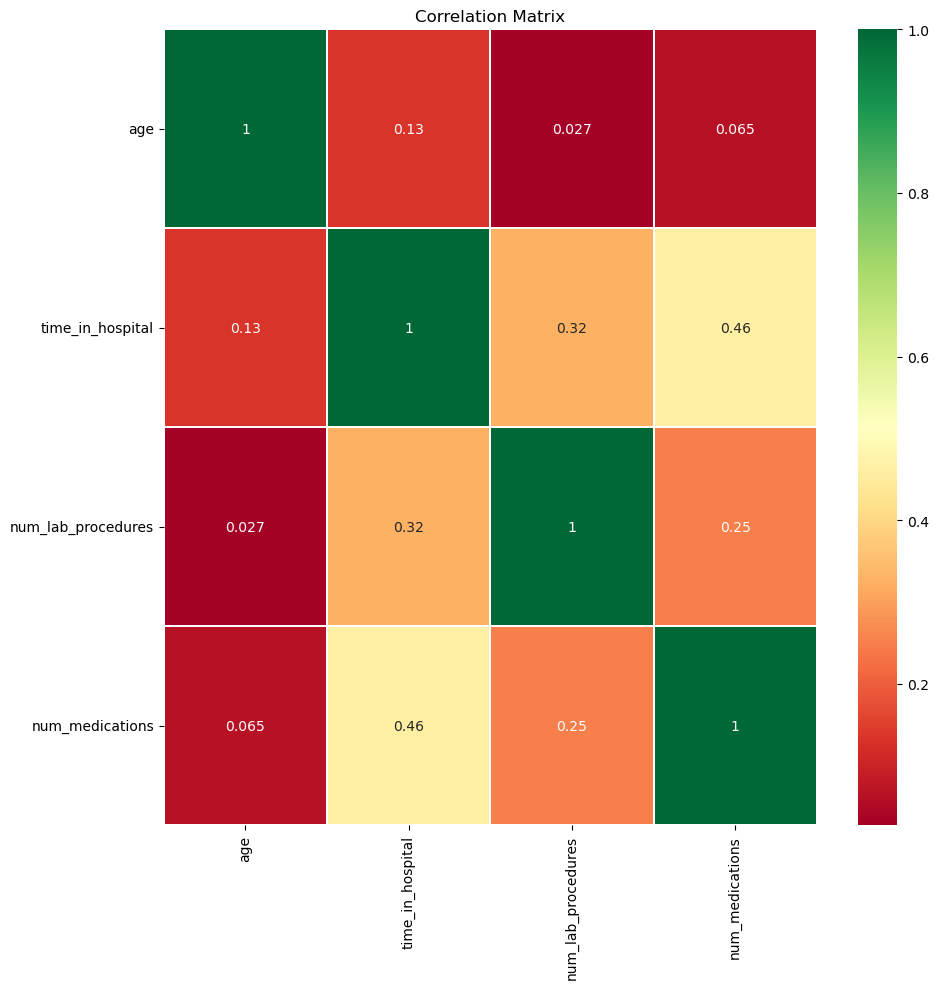

In [56]:

sns.heatmap(reduced_df.corr(numeric_only=True), annot=True, cmap='RdYlGn', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('Correlation_Matrix.png')

## Removing special characters 

In [57]:
# Replace '<30' with 'within30' in the 'readmitted' column
reduced_df['readmitted'] = reduced_df['readmitted'].replace('<30', 'within30')

reduced_df['readmitted'].value_counts()


readmitted
Otherwise    63294
within30      6239
Name: count, dtype: int64

In [58]:
# Change the readmitted data type to an object
reduced_df['readmitted'] = reduced_df['readmitted'].astype('object')

# Verify the change
print(reduced_df['readmitted'].dtype)


object


In [59]:
reduced_df.info()
reduced_df.describe()

reduced_df.to_csv('features_reduced.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 69533 entries, 0 to 101765
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   race                69533 non-null  object
 1   age                 69533 non-null  int64 
 2   payer_code          69533 non-null  object
 3   admission_type_id   69533 non-null  object
 4   time_in_hospital    69533 non-null  int64 
 5   num_lab_procedures  69533 non-null  int64 
 6   diag_1              69533 non-null  object
 7   num_medications     69533 non-null  int64 
 8   Glucose_Measured    69533 non-null  object
 9   A1Cmeasurement      69533 non-null  object
 10  insulin             69533 non-null  object
 11  change              69533 non-null  object
 12  readmitted          69533 non-null  object
dtypes: int64(4), object(9)
memory usage: 7.4+ MB


In [60]:
reduced_df.head()

,race,age,payer_code,admission_type_id,time_in_hospital,num_lab_procedures,diag_1,num_medications,Glucose_Measured,A1Cmeasurement,insulin,change,readmitted
0,Caucasian,5,Unknown,4,1,41,Diabetes,1,No,No,No,No,Otherwise
1,Caucasian,15,Unknown,1,3,59,Other,18,No,No,Up,Ch,Otherwise
2,AfricanAmerican,25,Unknown,1,2,11,Other,13,No,No,No,No,Otherwise
3,Caucasian,35,Unknown,1,2,44,Other,16,No,No,Up,Ch,Otherwise
4,Caucasian,45,Unknown,1,1,51,Neoplasms,8,No,No,Steady,Ch,Otherwise


In [61]:
X_reduced = reduced_df.drop('readmitted', axis=1)
y_reduced = reduced_df['readmitted']
X_reduced.columns

Index(['race', 'age', 'payer_code', 'admission_type_id', 'time_in_hospital',
       'num_lab_procedures', 'diag_1', 'num_medications', 'Glucose_Measured',
       'A1Cmeasurement', 'insulin', 'change'],
      dtype='object')

## Train-test split

In [62]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the 'readmitted' column
y_reduced = le.fit_transform(reduced_df['readmitted'])

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=.25, random_state=1000)

In [63]:
X_train

,race,age,payer_code,admission_type_id,time_in_hospital,num_lab_procedures,diag_1,num_medications,Glucose_Measured,A1Cmeasurement,insulin,change
28164,Caucasian,85,MC,1,6,52,Other,10,No,No,No,Ch
62813,Other,45,MC,4,3,7,Other,14,No,No,Up,Ch
78627,Caucasian,65,BC,2,3,45,Genitourinary System,12,No,Yes,Down,Ch
3024,Caucasian,75,Unknown,1,2,55,Digestive System,5,No,No,No,No
45897,Caucasian,65,MC,2,1,37,Other,8,No,No,Steady,Ch
...,...,...,...,...,...,...,...,...,...,...,...,...
81018,Caucasian,35,Unknown,1,2,72,Other,5,No,Yes,No,No
43304,AfricanAmerican,65,BC,2,3,30,Circulatory System,27,No,Yes,No,Ch
84007,Caucasian,35,MD,2,1,16,Genitourinary System,22,No,No,Steady,Ch
25779,Caucasian,35,DM,4,3,23,Other,18,Yes,No,No,No


In [64]:
X_test

,race,age,payer_code,admission_type_id,time_in_hospital,num_lab_procedures,diag_1,num_medications,Glucose_Measured,A1Cmeasurement,insulin,change
41127,Caucasian,25,CP,2,3,63,Other,12,No,No,No,No
76302,Other,55,SP,2,1,24,Circulatory System,18,No,No,Steady,No
83317,Caucasian,45,MC,1,7,60,Other,11,No,Yes,Up,Ch
33770,Caucasian,85,MC,1,4,17,Respiratory System,9,Yes,No,Steady,Ch
45489,Caucasian,55,MC,1,5,17,Circulatory System,19,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...
90206,Caucasian,65,Unknown,2,1,2,Other,12,No,No,No,Ch
76960,Caucasian,65,MC,1,14,78,Other,36,No,Yes,Up,Ch
61658,Caucasian,65,MC,1,4,32,Respiratory System,9,No,No,No,No
97345,Caucasian,85,MC,1,3,13,Other,20,No,No,Steady,Ch


In [65]:
y_train

array([0, 0, 1, ..., 0, 0, 0])

In [66]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [67]:
categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_features


Index(['race', 'payer_code', 'admission_type_id', 'diag_1', 'Glucose_Measured',
       'A1Cmeasurement', 'insulin', 'change'],
      dtype='object')

In [68]:
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns
numerical_features


Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_medications'], dtype='object')

## Building the Modeling Pipeline:
Steps:
1. Encode the categorical features
2. Scale the numerical features
3. Create the decision tree model
4. Fit the model


In [75]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import confusion_matrix


### Encoding categorical data and scalign numerical data ###
preprocessor = ColumnTransformer(transformers=[
        ('ohe', OneHotEncoder(categories="auto", handle_unknown="ignore"), categorical_features), 
        ('ss', StandardScaler(), numerical_features)])

### Pipeline including encoding, scaling, and estimator
model_pipeline= Pipeline([('preprocessor', preprocessor),
                        ('classifier', DecisionTreeClassifier(criterion='gini',splitter ='best',random_state=1000, max_depth = 12, class_weight= 'balanced'))])

model_pipeline



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'payer_code', 'admission_type_id', 'diag_1', 'Glucose_Measured',
       'A1Cmeasurement', 'insulin', 'change'],
      dtype='object')),
                                                 ('ss', StandardScaler(),
                                                  Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_medications'], dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=12,
                                        random_state=1000))])

In [76]:
## Fitting the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'payer_code', 'admission_type_id', 'diag_1', 'Glucose_Measured',
       'A1Cmeasurement', 'insulin', 'change'],
      dtype='object')),
                                                 ('ss', StandardScaler(),
                                                  Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_medications'], dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=12,
                                        random_state=1000))])

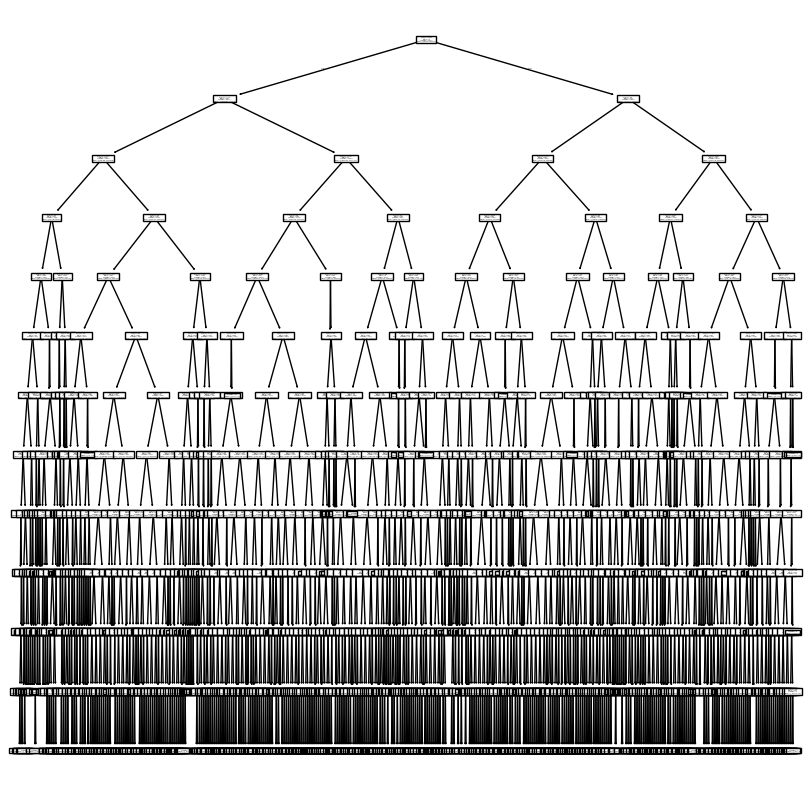

In [71]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(model_pipeline['classifier'], ax=ax);
plt.savefig('Model_3_Classifier_Tree.png')

# Evaluating the model

In [77]:
y_pred = model_pipeline.predict(X_test)

In [78]:
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [80]:
cfmat = confusion_matrix(y_test,y_pred, labels=model_pipeline.classes_)
cfmat

array([[8873, 6983],
       [ 730,  798]])

In [81]:

# Inverse transform the target to get original class labels
original_classes = le.inverse_transform([0, 1])


print("Class 0 represents:", original_classes[0])
print("Class 1 represents:", original_classes[1])


Class 0 represents: Otherwise
Class 1 represents: within30


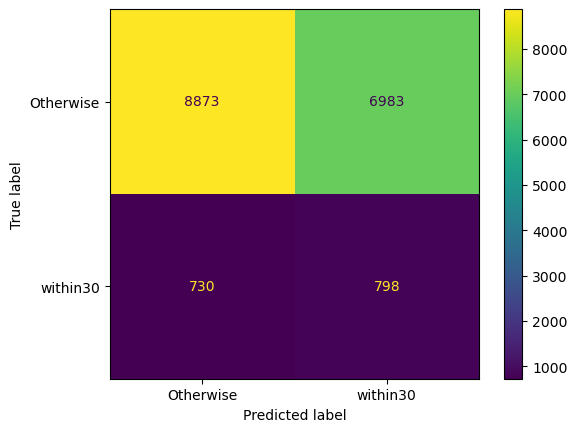

In [83]:

ConfusionMatrixDisplay.from_estimator(model_pipeline, X_test, y_test, display_labels=original_classes);
plt.savefig('Model_3_CFMAT.png')

In [84]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.8517814013027751
Recall: 0.5563161527841693
F1 Score: 0.6508440955541298


In [85]:

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.56      0.70     15856
           1       0.10      0.52      0.17      1528

    accuracy                           0.56     17384
   macro avg       0.51      0.54      0.43     17384
weighted avg       0.85      0.56      0.65     17384



The model is not doing well at predicting the minority class. It is still performing similarly to the baseline model. We need to implement a technique to help the model recognize the minority class better.

## Hyperparameter Tuning

We will try adjusting the max depth and the class weight to see if it improves the model's performance.

In [88]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, 15, 20]
}

grid_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['race', 'payer_code', 'admission_type_id', 'diag_1', 'Glucose_Measured',
       'A1Cmeasurement', 'insulin', 'change'],
      dtype='object')),
                                                                        ('ss',
                                                                         StandardScaler(),
                                                                         Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_medications'], dtype='object'))])),
                                       ('classifier',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               max_depth=12,
                                                               random_state=1000))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [3, 5, 7, 10, 15, 20]},
             scoring='recall')

In [89]:

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'classifier__max_depth': 7}
Best score: 0.5843952421800596


In [90]:
model_pipeline = grid_search.best_estimator_
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'payer_code', 'admission_type_id', 'diag_1', 'Glucose_Measured',
       'A1Cmeasurement', 'insulin', 'change'],
      dtype='object')),
                                                 ('ss', StandardScaler(),
                                                  Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_medications'], dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=7,
                                        random_state=1000))])

In [91]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'payer_code', 'admission_type_id', 'diag_1', 'Glucose_Measured',
       'A1Cmeasurement', 'insulin', 'change'],
      dtype='object')),
                                                 ('ss', StandardScaler(),
                                                  Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_medications'], dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=7,
                                        random_state=1000))])

In [92]:
#get predictions
y_pred = model_pipeline.predict(X_test)

In [93]:
cfmat = confusion_matrix(y_test,y_pred, labels=model_pipeline.classes_)
cfmat

array([[8155, 7701],
       [ 629,  899]])

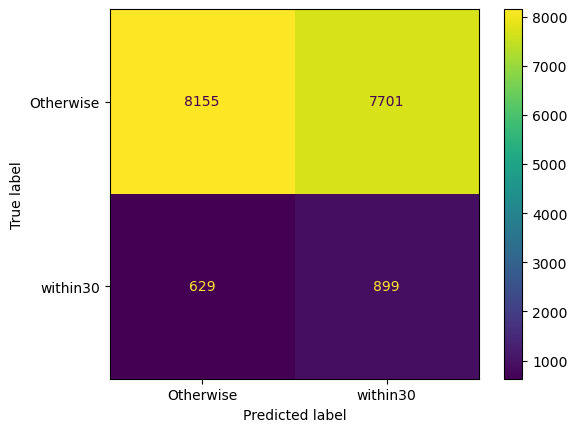

In [94]:

ConfusionMatrixDisplay.from_estimator(model_pipeline, X_test, y_test, display_labels=original_classes);

plt.savefig('Baseline_CFM.png')

In [95]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.51      0.66     15856
           1       0.10      0.59      0.18      1528

    accuracy                           0.52     17384
   macro avg       0.52      0.55      0.42     17384
weighted avg       0.86      0.52      0.62     17384



This hardly changed the model's performance.

## SMOTE Technique

We'll implement oversampling the minority class to see if it improves the model's performance.

In [109]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

model_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=1000)),
    ('classifier', DecisionTreeClassifier(
        criterion='gini',
        splitter='best',
        random_state=1000, 
        max_depth=10, 
        class_weight={0: 0.1, 1: 0.9}
    ))
])



In [110]:

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'payer_code', 'admission_type_id', 'diag_1', 'Glucose_Measured',
       'A1Cmeasurement', 'insulin', 'change'],
      dtype='object')),
                                                 ('ss', StandardScaler(),
                                                  Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_medications'], dtype='object'))])),
                ('smote', SMOTE(random_state=1000)),
                ('classifier',
                 DecisionTreeClassifier(class_weight={0: 0.1, 1: 0.9},
                                        max_depth=10, random_state=1000))])

In [111]:
y_pred = model_pipeline.predict(X_test)
cfmat = confusion_matrix(y_test,y_pred, labels=model_pipeline.classes_)
cfmat

array([[ 2231, 13625],
       [  145,  1383]])

In [112]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.14      0.24     15856
           1       0.09      0.91      0.17      1528

    accuracy                           0.21     17384
   macro avg       0.52      0.52      0.21     17384
weighted avg       0.86      0.21      0.24     17384



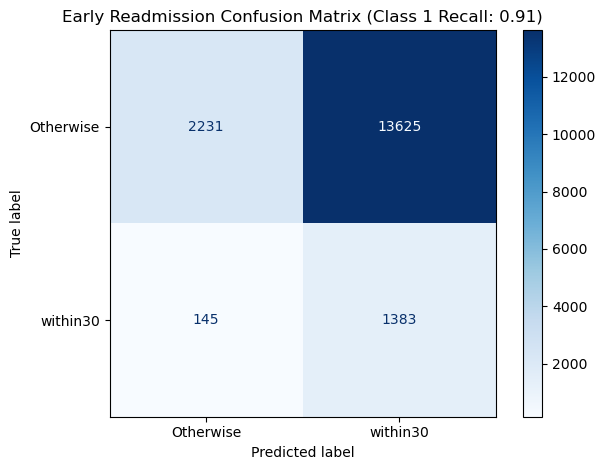

In [113]:
# Display confusion matrix for SMOTE-tuned classifier using ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model_pipeline, X_test, y_test, cmap='Blues', display_labels=original_classes)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
plt.title(f'Early Readmission Confusion Matrix (Class 1 Recall: {recall:.2f})')
plt.tight_layout()
plt.savefig('Model_3_CFMAT_SMOTE.png')

SMOTE has dramatically improved the model's ability to predict the minority class. This however came at the cost of very low precision. The accuracy is quite low and the model is worse at accurately predicting the majority class.

In [114]:
# Extract values from confusion matrix
tn, fp, fn, tp = cfmat.flatten()

# Display the values
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


True Negatives (TN): 2231
False Positives (FP): 13625
False Negatives (FN): 145
True Positives (TP): 1383


For our purposes, we care more about recall than precision. The cost of missing a true positive (early readmission of a diabetes patient) is much higher than the cost of falsely predicting a positive. It also isn't as important for us to predicting a true negative as it is to predicting a true positive. 

Given true positive represents the patients we positively identify to be readmitted within 30 days, we want to be able to predict as many of those as possible in order to save both the hospital and patients money.

In [115]:
   from collections import Counter
   print(Counter(y_test))

Counter({0: 15856, 1: 1528})


## Final Evaluation:

This model performs the best out of the three models. It has the highest recall score for readmission patients. It is also very precise at predicting the majority class. 

For our business purposes, catching 91% of early readmission patients is outstanding. If the average cost of a readmission is $15K, then based on the testing data, this model would save the hospital 20.5 million dollars. Since the average early readmission rate is 25%, detecting over 90% of these cases will have a huge impact on the hospital's savings and revenue.

## Future Steps:

Given the limitations of this dataset, I suggest we gather more recent and more representative data to train the model to be more precise at predicting early readmission patients. We should keep exploring and do more research on what other features are important indicators of early readmission and include them in training future models.